# Convolutional Neural Networks

## Introduction

We have built an analytical neural network from scratch, analyzed it, and understood its mechanisms. This was a great project to deepen our knowledge of neural networks but now it's time to take the next step. I want to understand deeply how a __convolutional neural network__ works, and how it is capable of classifyng vasts amount of different images. The only purpose of this notebook is to understand the internal mechanisms of a convolutional net and not at all the production of an optimized model. 

For our purpose, we will work with the MNIST handwritten digits dataset, since we don't want to bother with data cleansing, RGB images... 

## Theoretical background: How the convolutional net convolutes.

Ther first step is to understand how the convolutional net works. Its theoretical background is pretty simple, it's more difficult than the fully connected neural network (FCNN) but still simple. 

### Convolutional layers

The convolutional net is composed of one or multiple __convolutional layers__, just like the FCNN is composed of one or multiple hidden layers. The convolutional layers are composed themselves of __Kernels__. Each kernel itself has different __filters__, which are just matrices of weights that we correlate over the input image to generate the output. Now we shall explain the paper each component plays in the general picture.

Suppose we had one RGB image. This RGB image is a 28x28 pixels image with 3 different channels with the values of the red, green and blue proportions each, so the input has shape (3, 28, 28). Well, we want to pass that image through our first convolutional layer which has, for example, 8 kernels. Each kernel is made of as many filters as input channels the convolutional layer receives, so each filter corresponds to each input channel. Then, in this case, each one of the 8 kernels has 3 filters, one for the red channel, one for the green channel and one for the blue channel. These filters are just matrices of weights that we correlate with the input image, so we'll suppose they are just 5x5 filters. So, to sum up, the convolutional layer is composed of 8 kernels of 3 different 5x5 filters, so it is shaped (8, 3, 5, 5).

Well, to compute the output of the convolutional layer we do the following: for each kernel, we sum up the correlation of all the filters with their corresponding channel input, so if the input is shaped (3, 28, 28) and we have 8 kernels in the convolutional layer the output will have shape (num_kernels, input_size-filter_size+1, input_size-filter_size+1) = (8, 28-5 +1, 28-5+1) = (8, 24, 24). To that result, for each kernel, we add its bias, which can be a simple scalar or a whole 24x24 map like in our case. 

The next layer now has 8 different 8 input channels and so its kernels will have 8 different filters of whatever the size you want. Suppose it has 16 different 5x5 filters, then its output would be (16, 20, 20), that is, the sum of the correlation of each one of the 8 filters of each kernel with the input plus the kernel's bias.

Do not confuse the correlation with the convolution, to compute the correlation you just put the filter above the input, multiplying it element by element and then adding all the values up. That is one correlation, then you move the filter thoroughout the whole image to generate the output, i.e. __a feature map__. The convolution is exactly the same but rotating the filter by 180 degrees. The forward process uses only the correlation operation whereas in the backpropagation we need to compute the convolution. I will not explain much further these operations since there are better sources of information out there.


## Data. torchvision.datasets

First we will start by collecting the MNIST handwritten dataset just like we did for the analytical net.

In [263]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

In [264]:
train_data = datasets.MNIST(
    root = "./train_MNIST",
    download = True,
    train = True,
    transform = ToTensor()
)

test_data = datasets.MNIST(
    root = "./test_MNIST",
    download = True,
    train = False,
    transform = ToTensor()
)

In [265]:
print(isinstance(train_data, datasets.MNIST))
print(isinstance(test_data, datasets.MNIST))

True
True


In [266]:
train_images = train_data.data / 255
train_labels = train_data.targets 

test_images = test_data.data / 255
test_labels = test_data.targets

In [267]:
train_images.shape

torch.Size([60000, 28, 28])

## Auxiliary functions. get_batches

Now we will define the get_batches function. Since PyTorch datasets offer already a set of data split into training and validation there's no need to define a train_test_split function. Nonetheless, if we were to work with a custom dataset we would need to implement it.

In [268]:
def get_batches(data, labels, batch_size = 32, shuffle = True):
    number_of_samples = labels.shape[0]
    indices = torch.arange(number_of_samples)
    x = data[indices]
    y = labels[indices]
    
    if shuffle:
        indices = torch.randperm(number_of_samples)
        x = data[indices]
        y = labels[indices]
        
    for idx in range(0, number_of_samples, batch_size):
        x_batch = x[idx:idx+batch_size]
        y_batch = y[idx:idx+batch_size]
        yield x_batch, y_batch
        

In [269]:
for x_batch, y_batch in get_batches(train_images, train_labels):
    print(f"\nX_batch: {x_batch.shape} || y_batch: {y_batch.shape}\n")
    break


X_batch: torch.Size([32, 28, 28]) || y_batch: torch.Size([32])



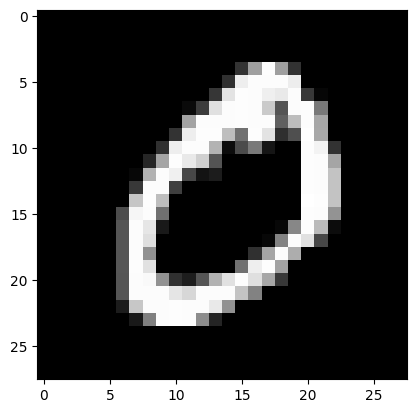

In [270]:
import matplotlib.pyplot as plt

index = 1

image = train_images[index]
plt.imshow(image, cmap="grey")

So, there are our images. Now, instead of just flattening those images to feed our net a 28x28 inpute vector, we will feed the whole 2D image. There are two great reasons to make this:

1º) __Flattened vectors lose all spatial information__. The ANN we built is capable of understanding that different combinations of pixel values correspond to different labels but it does not really understand what's going on in the image. Suppose we had to detect a face instead of a number, the main features corresponding to a face could be the eyes and the nose, but, in order to identify a face, these features must retain an important spatial positioning, both eyes must be above and symetrically apart from the nose. If not, we wouldn't picture a face.  

2º) A fully connected layer with black and white images of maybe, 144px144p = 20736 pixels, would need 20736 weights for each neuron of the input layer which may be composed of 512 neurons, so that would add up to around 20736x512 ~ __10 million weights__, that is, a matrix composed of 512 rows with 20736 columns, each element being the weight corresponding to a given pixel of a given neuron. So yep, that escales pretty fast and results completeley inefficient.  

## Kernels 

Each convolutional layer is composed of a set of d kernels (suppose d = 16), that is, the depth of the layer. If there are n input channels, then, each kernel has shape (n, kernel_size, kernel_size), for example, if we had 8 input channels, and 3x3 filters, then each kernel is a 3D tensor (8, 3, 3), and so with 16 kernels the whole layer would be shaped (16, 8, 3, 3). That is, the layer has 16 kernels, composed each one of them by 8 3x3 matrices. 

Since our images are square (28x28), we will build square filters of 3x3. __The vast majority of filters are odd_sized__. That is because odd_sized matrices have a center whereas even-sized ones do not. The existence of a center in these filters allow them to preserve symmetry in spatial structure, detecting edges, corners and patterns more efficiently, i.e. __an odd-sized filture ensures both horizontal and vertical symmetry conservation.__. In addition, odd-sized filters make __padding__ (adding pixels so the output matrix of the filter is the same size as the input matrix) easier.  

In [271]:
import scipy.signal as signal
import torch.nn.functional as F

class kernel():
    def __init__(self, input_shape, filter_size):
        self.filter_size = filter_size # (3)
        self.input_shape = input_shape # shape of the image (1, 28, 28)
        self.input_size = self.input_shape[1] # dimension of the image (28)
        self.num_filters = self.input_shape[0] # num of input channels (num of filters)
        self.output_size = self.input_size - self.filter_size + 1 # (26)

        self.filters = []
        for i in range(self.num_filters):
            self.filters.append(torch.randn(self.filter_size, self.filter_size))

        self.filters = torch.stack(self.filters, dim = 0)
        self.bias = torch.randn(self.output_size, self.output_size)
        
        

class conv_layer():
    def __init__(self, input_shape, num_kernels, filter_size):
        self.num_kernels = num_kernels
        self.filter_size = filter_size
        self.input_shape = input_shape
        self.input_size = input_shape[1]
        self.num_filters = input_shape[0]
        self.output_size = self.input_size - self.filter_size + 1
        
        self.kernels = []
        for i in range(self.num_kernels):
            self.kernels.append(kernel(self.input_shape, self.filter_size))


    def forward(self, X_input):
        self.input = X_input
        self.output = torch.zeros(self.num_kernels, self.output_size, self.output_size)

        for i, kernel in enumerate(self.kernels):
            for j in range(self.num_filters):
                channel_input = self.input[j]
                channel_filter = kernel.filters[j]

                self.output[i] += F.conv2d(
                    channel_input.float().unsqueeze(0).unsqueeze(0),
                    channel_filter.unsqueeze(0).unsqueeze(0)
                ).squeeze()
                
            self.output[i] += kernel.bias
        return self.output

    
    def backwards(self, grad_output, lr = 0.01):
        grad_filter = torch.zeros(self.num_kernels, self.num_filters, 
                                  self.filter_size, self.filter_size)

        grad_input = torch.zeros(self.num_filters, self.input_size, self.input_size)
        
        for i, kernel in enumerate(self.kernels):
            kernel_grad_output = grad_output[i]
            
            for j in range(kernel.num_filters):
                channel_input = self.input[j]
                channel_filter = kernel.filters[j]
                
                grad_filter[i, j] += F.conv2d(
                    channel_input.float().unsqueeze(0).unsqueeze(0),
                    kernel_grad_output.unsqueeze(0).unsqueeze(0)
                ).squeeze()

                channel_filter_flipped = torch.flip(channel_filter, dims = [0,1])

                grad_input[j] += F.conv2d(
                    kernel_grad_output.unsqueeze(0).unsqueeze(0),
                    channel_filter_flipped.unsqueeze(0).unsqueeze(0),
                    padding = (self.filter_size-1, self.filter_size-1)
                ).squeeze()


        for i, kernel in enumerate(self.kernels):
            kernel.filters -= lr * grad_filter[i]

            grad_bias = grad_output[i]
            kernel.bias -= lr * grad_bias 

        return grad_input

In [272]:
X = torch.randint(0, 2, (1, 28, 28))
conv_test = conv_layer((1, 28, 28), num_kernels = 8, filter_size = 3)
print(X[0, 0:8, 0:8])

tensor([[0, 0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 0, 0, 1, 0]])


In [273]:
print(conv_test.kernels[0].filters)

tensor([[[-1.9304, -1.3231, -1.5722],
         [-0.1500, -2.5906, -0.7200],
         [ 0.2547, -0.8891, -0.5422]]])


In [274]:
print(conv_test.forward(X).shape)
output = conv_test.forward(X) - conv_test.kernels[0].bias 
output[0, 0:8, 0:8]

torch.Size([8, 26, 26])


tensor([[-3.6297, -2.0097, -3.4744, -7.2698, -2.6497, -3.1070, -3.4689, -4.5480],
        [-6.4784, -3.0879, -5.7719, -4.5289, -5.9332, -4.3497, -5.3203, -4.9528],
        [-4.6980, -4.1179, -5.4858, -4.9756, -6.0879, -8.8476, -6.3300, -5.5892],
        [-5.9940, -4.1948, -2.2122, -1.6756, -2.8345, -5.5228, -6.5306, -2.3622],
        [-3.5409, -4.0818, -3.2250, -0.4375, -3.1814, -5.2311, -4.6657, -5.9523],
        [-1.5044, -5.1703, -4.9528, -2.5457, -4.7050, -2.3622, -3.9679, -4.6336],
        [-7.6745, -4.9419, -6.4784, -3.3978, -2.5853, -5.9523, -2.3566, -2.6405],
        [-7.7406, -7.5976, -3.8089, -2.6226, -3.1814, -4.3789, -5.2132, -1.0391]])

## Activation functions

Just like analytical nets, convolutional nets need activation functions in order to add non-linearity to the system. Otherwise the whole net would be somewhat an extremely overcomplicated linear regression. During my first tries I actually used ReLU() activation functions but it turns out that these activations would just kill all outputs. The whole system would then predict always the same number no matter the input, since there was no more information apart from the bias of each layer. To solve this problem I simply switched to hyperbolic tangents.

In [275]:
class ReLU():
    def forward(self, X_input):
        self.mask = X_input > 0
        return self.mask * X_input

    def backwards(self, grad_output):
        return self.mask * grad_output

        
class softmax():
    def forward(self, X_input):
        return torch.softmax(X_input, dim = 1)

    def backwards(self, grad_output):
        return grad_output # we will calculate it inside the training loop

class tanh():
    def forward(self, X_input):
        self.input = X_input
        self.output = torch.tanh(self.input)
        return self.output

    def backwards(self, grad_output):
        grad_input = grad_output * (1- self.output**2)
        return grad_input
        
class reshape_layer():
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, X_input):
        return torch.reshape(X_input, self.output_shape)

    def backwards(self, grad_output):
        return torch.reshape(grad_output, self.input_shape)

## Fully connected layers

To actually solve the classification problem we need a number so the whole system must end in an analytical neural net. We define below the basic classes we need for our final part of the convolutional net

In [276]:
import torch
import scipy.signal as signal

class dense():
    def __init__(self, output_size, input_size):
        self.ouput_size = output_size
        self.input_size = input_size
        self.W = torch.randn(output_size, input_size) * 0.01
        self.bias = torch.randn(output_size, ) * 0.01

    def forward(self, X_input):
        self.input = X_input
        
        Z = self.input @ self.W.T + self.bias
        return Z

    def backwards(self, grad_output, lr = 0.01):
        self.dW = grad_output.T @ self.input 
        self.db = grad_output.sum(dim = 0)
        self.dX = grad_output @ self.W

        self.W -= self.dW * lr
        self.bias -= self.db * lr
        
        return self.dX

In [277]:
X = torch.randn(16, 24, 24)
Y = torch.randn(1, 9216)

In [278]:
ReSHAPE = reshape_layer((16, 24, 24), (1, 9216))
print(f"\nReSHAPE.forward: {ReSHAPE.forward(X).shape}\n")
print(f"\nReSHAPE.backwards: {ReSHAPE.backwards(Y).shape}\n")


ReSHAPE.forward: torch.Size([1, 9216])


ReSHAPE.backwards: torch.Size([16, 24, 24])



## Convolutional net

We have everything we need to define a simple comvolutional net capable of classifying handwritten digits from the MNIST dataset. We could also extrapolate it to some other datasets but for now we'll stick to this simple one.

In [323]:
C1 = conv_layer((1, 28, 28), num_kernels = 8, filter_size = 3)
C2 = conv_layer((8, 26, 26), num_kernels = 16, filter_size = 3)

first_layer = dense(256, 9216)
second_layer = dense(10, 256)

ReSHAPE = reshape_layer((16, 24, 24), (1, 9216))

In [324]:
network = [
    C1,
    tanh(),
    C2,
    tanh(),
    ReSHAPE,
    first_layer,
    tanh(),
    second_layer,
    softmax()
]

In [325]:
num_epochs = 8

for epoch in range(num_epochs):
    epoch_cross_entropy = 0
    for x_batch, y_batch in get_batches(train_images[0:256], train_labels[0:256], batch_size = 1):
        output = torch.reshape(x_batch, (1,28,28))
    
        for layer in network:
            output = layer.forward(output)
            
        epoch_cross_entropy += -torch.log(output[0, y_batch] + 1e-9)
                
        grad = output.clone()
        grad[0, y_batch] -= 1
    
        for layer in reversed(network):
            grad = layer.backwards(grad)

    print(f"\nC1_grad_kernel[0]: {C1.kernels[0].filters}")
    print(f"\nC2_grad_kernel[0]_filter[0]: {C2.kernels[0].filters[0]}\n")
            
    print("avg_cross_entropy_epoch: %.10f"%(epoch_cross_entropy / 128))
    


C1_grad_kernel[0]: tensor([[[ 1.3038, -1.0976, -2.0285],
         [-0.2930, -2.4859,  1.5220],
         [ 1.4795,  0.3445,  0.0322]]])

C2_grad_kernel[0]_filter[0]: tensor([[-0.5456,  1.3993, -1.3253],
        [ 0.7092,  0.2416,  0.8926],
        [ 1.6418,  1.1173, -0.7717]])

avg_cross_entropy_epoch: 3.5464587212

C1_grad_kernel[0]: tensor([[[ 1.2884, -1.1228, -2.0501],
         [-0.3022, -2.5000,  1.5069],
         [ 1.4895,  0.3523,  0.0398]]])

C2_grad_kernel[0]_filter[0]: tensor([[-0.5439,  1.3982, -1.3259],
        [ 0.7099,  0.2411,  0.8922],
        [ 1.6436,  1.1162, -0.7717]])

avg_cross_entropy_epoch: 1.9046502113

C1_grad_kernel[0]: tensor([[[ 1.2885, -1.1323, -2.0628],
         [-0.2962, -2.4993,  1.5066],
         [ 1.5049,  0.3685,  0.0573]]])

C2_grad_kernel[0]_filter[0]: tensor([[-0.5433,  1.3958, -1.3279],
        [ 0.7126,  0.2415,  0.8904],
        [ 1.6477,  1.1178, -0.7702]])

avg_cross_entropy_epoch: 1.1476808786

C1_grad_kernel[0]: tensor([[[ 1.2880, -1.1455, -

I printed the gradients of the convolutional layers just to check if the net is updating properly.

In [327]:
def predict(X):
    output = torch.reshape(X, (1,28,28))
    
    for layer in network:
        output = layer.forward(output)
    
    return torch.argmax(output)

In [328]:
index = 20

X = test_images[index]

print(f"Prediction: {predict(X)}")
print(test_labels[index])

Prediction: 9
tensor(9)


In [329]:
print(train_labels[0:128]) 

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4])


In [330]:
C1.kernels[7].filters

tensor([[[ 0.4968, -1.4927, -2.6440],
         [ 1.4467,  0.5834,  1.6060],
         [ 0.3895, -0.2313, -0.1774]]])

In [331]:
first_layer.W[0:10, 0:10]

tensor([[-8.9222e-03,  7.6019e-03,  8.5144e-03,  1.2319e-02,  1.8436e-02,
         -7.3416e-03,  5.7812e-03,  5.7934e-03,  9.5066e-03,  7.6494e-03],
        [ 9.9666e-03,  6.0147e-03, -6.6286e-04,  4.8188e-03,  9.7260e-03,
          1.4292e-02, -2.3814e-02,  4.5273e-03,  5.3329e-03, -9.6547e-03],
        [-8.3818e-03,  4.8813e-03, -1.9514e-02, -7.9606e-03, -5.4329e-03,
         -3.3243e-03,  4.7348e-03, -3.0412e-03, -8.1844e-03, -1.5458e-03],
        [-1.0228e-02, -1.2123e-02,  1.6026e-02, -1.0977e-03, -1.6294e-02,
          1.4015e-02,  1.6712e-02, -7.4382e-03, -1.3336e-02,  2.0984e-03],
        [-5.1576e-03, -3.0362e-03, -2.4015e-03, -1.4449e-03, -7.6041e-03,
          9.9156e-03, -1.4193e-02, -3.4258e-03,  1.0967e-02,  1.1573e-02],
        [-9.1788e-03,  2.0512e-02, -1.1336e-05, -1.8866e-02, -5.0205e-03,
         -1.4194e-02,  1.3158e-02, -4.2693e-03,  1.1917e-02, -1.9262e-03],
        [-1.4587e-03, -8.6292e-03, -1.4857e-02,  6.5301e-03, -3.7493e-03,
         -3.4783e-03,  8.6979e-0

In [332]:
test_images = test_data.data
test_labels = test_data.targets

In [333]:
counter = 0
failed_indexes = []

for i in range(1000):
    image = test_images[i]
    image.reshape(1,28,28)
    label_pred = predict(image)
    label_true = test_labels[i]

    if label_pred == label_true:
        counter += 1 

    else:
        failed_indexes.append(i)

print(f"\nSuccesfully classified percentage of labels in the first 1000 digitis of the test dataset:\n{counter/1000:.4f}\n")


Succesfully classified percentage of labels in the first 1000 digitis of the test dataset:
0.7430



In [334]:
print(f"Some failed indexes: {failed_indexes[0:10]}")

Some failed indexes: [7, 8, 11, 15, 18, 22, 38, 45, 52, 53]


## Visualizing the filters

We shall now try to visualize the convolutional filters based on different inputs to the net. First, we will visualize the first convolutional layer of the model, this layer outputs 8 different features maps, each one resulting on the convolution of its channel filter with the input image. Each filter has been trained to classify handwritten digits of mnist and so each one should specialize in different features of these digits. We will try to visualize this by using heatmaps of each feature map based on different inputs. 

Number: 9
Prediction: 4


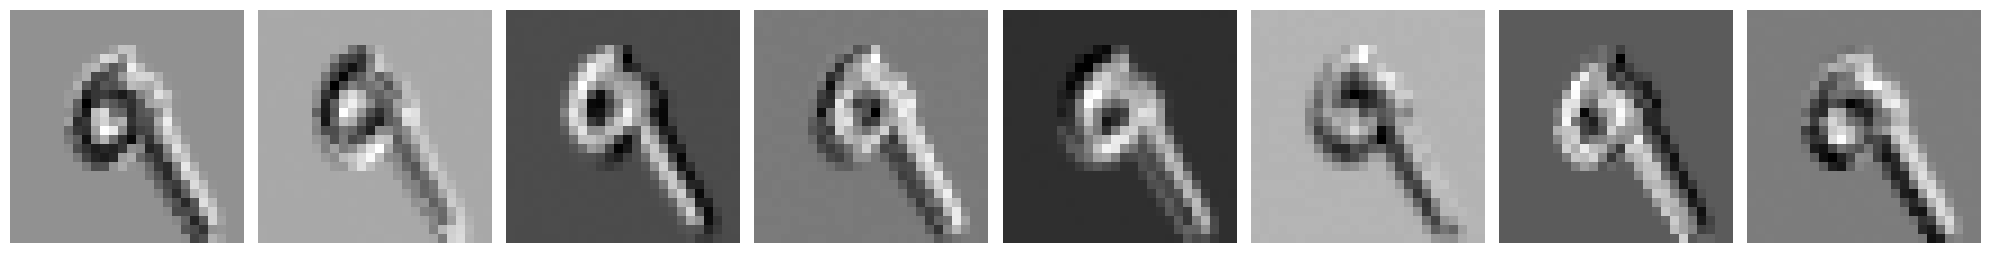

In [335]:
index = 7

image = test_images[index]

inpt = torch.reshape(image, (1, 28, 28))
print(f"Number: {test_labels[index]}")
print(f"Prediction: {predict(inpt)}")

features_maps_test_image = C1.forward(inpt)

fig, axes = plt.subplots(1, 8, figsize = (20,8))

for i, fmap in enumerate(features_maps_test_image):
    axes[i].imshow(fmap, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()    
plt.show()

In [336]:
features_maps_C1_output = C2.forward(features_maps_test_image)

In [337]:
features_maps_C1_output.shape

torch.Size([16, 24, 24])

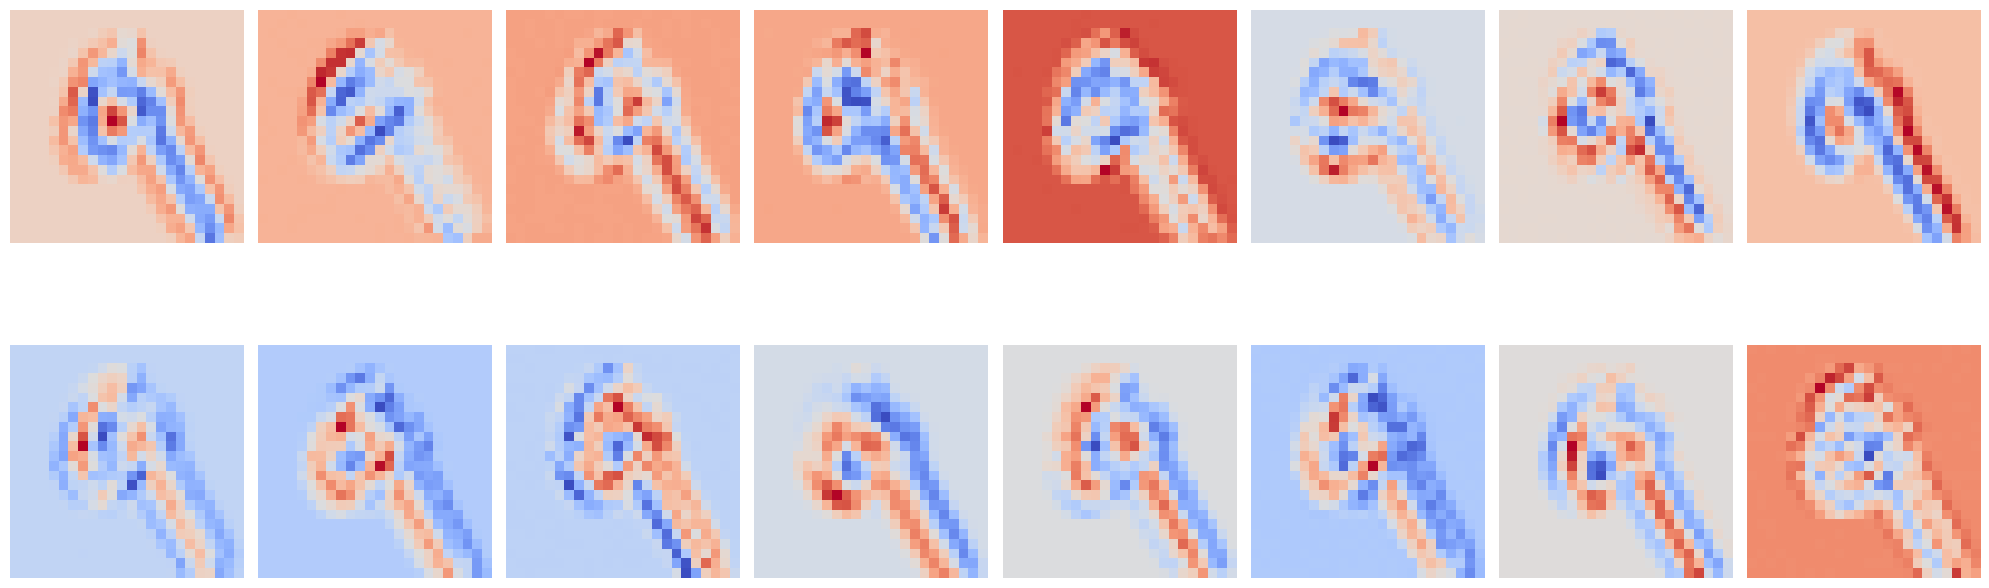

In [340]:
fig, axes = plt.subplots(2, 8, figsize=(20, 8))

# axes is a 2D array (2x8), flatten it to iterate easily
for i, ax in enumerate(axes.flat):
    ax.imshow(features_maps_C1_output[i], cmap='coolwarm')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Analyzing the results

You see the net we have trained has a couple of important problems. The first one is that it does not admit any batches, and so it really will not generalize, instead, each epoch it will try to adjust the parameters of all the filters so each one of them matches the given number, and doing so for 128-256 digits will make up something that basically generalizes poorly, but can somewhat predict the number given on what the net has seen during training.

Moreover, the size of the training dataset is way smaller than it should to properly train a net. Our only purpose was to understand the internal processes of a convolutional net, and so we did not care about performance, and, well there is a huge bottleneck in our architecture which is the first analytical hidden layer, whose weight matrix is shaped (256, 9216), so that adds up to more than 2.3M weights, way more than any other layer. 

Without batches, the net has to compute the convolutions, matrix multiplications, correlations, updating... of the whole forward and backwards processes for each image, and, even worse, given that there's no pooling of the images, the first hidden layer has more than 2.3M weights so that is a lot of computation. In comparison, any of the previous fully connected neural networks we set up had less weights than just the first hidden layer of this one.    

All of this lead to one obvious problem, the net can not be properly trained. We need to add pooling and batches in order to achieve a good accuracy. 

## Conclusion

Even though our convolutional net has some important flaws, the whole point of this project was to understand how a convolutional net forwarded some given input and how it updated its own parameters during the backpropagation process. So, given that our net is capable of doing just that, we succesfully tackled the original problem. There's still a lot of work to do and this notebook settles my first step on convolutional networks.